## Bài toán phân loại sử dụng SVM 

Mục tiêu: 

- Xây dựng được mô hình svm sử dụng thư viện sklearn. 
- Ứng dụng, hiểu cách áp dụng mô hình svm vào giải quyết bài toán thực tế (vd: phân loại văn bản) 
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 


In [ ]:
!pip install pyvi

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

from sklearn.datasets import load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

## 1. Load dữ liệu từ thư mục đã crappy từ trước 

Cấu trúc thư mục như sau 

- data/news_1135/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [2]:
data_train = load_files(container_path="data/news_1135/", encoding="utf-8")

print(data_train.filenames)
print()

print("Tong so file: {}" .format( len(data_train.filenames)))


['data/news_1135/Tin khác/0218e1df21ce358b9c6485176a48f1fcaeedef67.txt'
 'data/news_1135/Khoa học - Công nghệ/bf9889f5f2ffd6c92fa877d35ef0ef5f34f0666d.txt'
 'data/news_1135/Tin khác/d74aab054ffe9f8661df13bc52b438b48a63fe48.txt'
 ...
 'data/news_1135/Thời sự/a06c1ec4c146d3b4eb5070a1967e10e5e21bdc5b.txt'
 'data/news_1135/Sức khỏe/4187c4a1d528fd9ea4630d2709229df0b0d09c3d.txt'
 'data/news_1135/Thể thao/7adaf0c561796f2411340150f18417543ad4403c.txt']

Tong so file: 1135


###  Tiền xử lý dữ liệu đưa dữ liệu từ dạng text về dạng ma trận 

- Thử nghiệm để kiểm tra hoạt động chuyển hoá dữ liệu về dạng ma trận 

In [3]:
# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print(stopwords[:10])

# 
# Transforming data 
# Chuyển hoá dữ liệu text về dạng vector tfidf 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)

model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
# print(module_count_vector.vocabulary_)
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print("10 từ đầu tiên trong từ điển:")
i = 0
for k,v in module_count_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 10:
        break 


['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']
10 từ đầu tiên trong từ điển:
1 :  ('dân_trí', 6928)
2 :  ('sở', 17869)
3 :  ('gd', 7729)
4 :  ('đt', 23214)
5 :  ('tỉnh', 20851)
6 :  ('gia_lai', 7816)
7 :  ('văn_bản', 21779)
8 :  ('2258', 858)
9 :  ('sgdđt', 17039)
10 :  ('vp', 21572)
11 :  ('chấn_chỉnh', 4971)


### Bài 1: sử dụng TfidfVectorizer

In [4]:
# Giải
# sử dụng TfidfVectorizer
tfidf_vector = TfidfVectorizer(stop_words=stopwords)
data_preprocessed2 = tfidf_vector.fit_transform(data_train.data, data_train.target)
i = 0
for k,v in tfidf_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 10:
        break

1 :  ('dân_trí', 6928)
2 :  ('sở', 17869)
3 :  ('gd', 7729)
4 :  ('đt', 23214)
5 :  ('tỉnh', 20851)
6 :  ('gia_lai', 7816)
7 :  ('văn_bản', 21779)
8 :  ('2258', 858)
9 :  ('sgdđt', 17039)
10 :  ('vp', 21572)
11 :  ('chấn_chỉnh', 4971)


In [5]:
# top 3 từ trong văn bản đầu tiên có tfidf cao nhất
feature_array = np.array(tfidf_vector.get_feature_names())
tfidf_sorting = np.argsort(data_preprocessed2[0].toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

['sách' 'học_sinh' 'tuyệt_đối']


### Chia dữ liệu làm 2 phần training và testing 

- Training chiếm 80 % dữ liệu 
- Testing chiếm 20 % dữ liệu 

In [21]:
from sklearn.model_selection import ShuffleSplit

test_size = 0.2
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split( data_preprocessed, data_train.target, test_size=test_size)

print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

Dữ liệu training =  (908, 24389) (908,)
Dữ liệu testing =  (227, 24389) (227,)


## 2. Training svm model 

Sử dụng thư viện sklearn để xây dựng mô hình 
- `svm.SVC(kernel='linear', C=1.0)`: chọn hàm nhân phân tách là linear, tham số C=1.0 

In [9]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)
print("- model - train complete")

- Training ...
- Train size = (908, 24389)
- model - train complete


## 3. Testing svm model 

Thực hiện dự đoán nhãn cho từng văn bản trong tập test 

Độ đo đánh giá: 
> accuracy = tổng số văn bản dự đoán đúng  / tổng số văn bản có trong tập test  

In [10]:
from sklearn.metrics import accuracy_score
print("- Testing ...")
y_pred = model.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))


- Testing ...
- Acc = 0.8986784140969163


### Bài 4: Dự đoán nhãn của văn bản

In [11]:
# Tiền xử lý dữ liệu sử dụng module model_rf_preprocess. 
new_doc = "Công phượng ghi bàn cho đội tuyển Việt nam"
# Trước hết, cần thực hiện tách từ sử dụng pyvi
tokenized_new_doc = ViTokenizer.tokenize(new_doc)
# Cần đưa văn bản ở dạng mảng/vector
tokenized_new_doc = [tokenized_new_doc]
print(tokenized_new_doc)
# Rồi sử dụng module model_rf_preprocess
input_data_preprocessed = model_rf_preprocess.transform(tokenized_new_doc)
print(input_data_preprocessed)

label = model.predict(input_data_preprocessed)
print('label ', label, '-', data_train.target_names[label[0]])

['Công phượng ghi_bàn cho đội_tuyển Việt_nam']
  (0, 24149)	0.4617859604824952
  (0, 21498)	0.23577234678310735
  (0, 15553)	0.6394232142292748
  (0, 7777)	0.4617859604824952
  (0, 5847)	0.33023750089838017
label  [5] - Thể thao


## 4. Bài tập bổ sung: 

### 4.1 Thử nghiệm các tham số 

- Các tham số với giá trị khác nhau có thể ảnh hưởng để kết quả học 
- Cần thử nghiệm kỹ lượng để đưa ra kết quả khách quan: tham số C, gamma, kernel. 
    - Chọn mô hình với bộ tham số cho kết quả tốt nhất 
- Gợi ý: 
    - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    - Sử dụng grid search

#### Bài 4: Vẽ Learning curve khảo sát Acc của SVM-linear với tham số C thay đổi

In [12]:
# hàm sinh id màu  
def get_cmap(n):
    return 'C' + str(n)

# Hàm thực hiện training model, crossvalidate và vẽ lên đồ thị sử dụng mat libplot 
def plot_learning_curve(estimator, title, label_curve, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), new_plot=False,
                        idx_color=0):
    
    # Khởi tạo bức ảnh mới với thư viện plot lib 
    if new_plot:
        # plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Accuracy")
        plt.grid()
    
    # chú thích nếu có 
    if ylim is not None:
        plt.ylim(*ylim)
        
    # thực hiện training model, ghi nhận các giá trị trong quá trình training 
    # cv = số fold cross validate, số phần bộ dữ liệu được chia để thực hiện training testing.
    # train_sizes = mảng tỉ lệ, các tỉ lệ được hệ thống chọn làm điểm dừng để thực hiện 1 testing 
    #  train_sizes = [0.3, 0.5] => hệ thống lấy 30 % dữ liệu để train và thực hiện test, tương tự 50 % ..
    # scoring = hàm mục tiêu để đánh giá chất lượng mô hình và vẽ lên đồ thị 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
    # Lấy trung bình cộng các giá trị output của các fold 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # random 1 màu để vẽ 
    color = get_cmap(idx_color)
    
    # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=color)
    plt.plot(train_sizes, test_scores_mean, 'o-', color=color,
             label=label_curve)

    plt.legend(loc="best")
    return plt

In [ ]:
list_C = [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100]
# model title 
title = "Learning Curves SVM, Linear kernel, change C"

# duyệt qua mảng các giá trị của tham số C 
for i, C in enumerate(list_C):
    # Với từng giá trị C nhận được, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = Pipeline([ 
                         ('clf', svm.SVC(kernel='linear', C=C)), # mô hình svm với tham số C 
                         ])
    
    plt = plot_learning_curve(text_clf, title, "C = %f" % (C),
                              data_preprocessed, data_train.target,
                              (0.0, 1.01), cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)

# lưu hình ảnh ra file 
# plt.savefig('images/changeC.png', bbox_inches='tight')
plt.show()


#### Bài 5: Sử dụng GridSearchCV để tìm bộ tham số tốt nhất

In [22]:
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf', 'poly'] }

model = svm.SVC()
#Create the GridSearchCV object
best_model = GridSearchCV(model, params_grid, cv=4, n_jobs=-1, scoring = "accuracy")

#Fit the data with the best possible parameters
best_model.fit(X_train, y_train)

#Print the best estimator with it's parameters
print (best_model.best_params_)
print (best_model.best_estimator_)
# Test best_model
print('Testing')
y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)
Testing
0.8502202643171806


### 4.2 Phân loại số viết tay 

Dữ liệu training =  (1437, 64) (1437,)
Dữ liệu testing =  (360, 64) (360,)


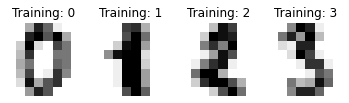

In [18]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
target = digits.target
X_train, X_test, y_train, y_test = train_test_split( data, target, test_size=test_size)

print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

### Bài 6

In [19]:
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf', 'poly'] }

model = svm.SVC()
#Create the GridSearchCV object
best_model = GridSearchCV(model, params_grid, cv=4, n_jobs=-1, scoring = "accuracy")

#Fit the data with the best possible parameters
best_model.fit(X_train, y_train)

#Print the best estimator with it's parameters
print (best_model.best_params_)
print (best_model.best_estimator_)
# Test best_model
print('Testing')
y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)
Testing
0.9805555555555555
